# Imports & basics

In [1]:
# -- path info --
path_to_repo = "/Users/mbaranov/python_wd/credit_scoring_project"
dataset_nm = "01_german"

# -- experiments logging --
experiment_dir = "test"
! mkdir "test"
# -- --

n_total = 200
top_k = 20

load = False                      # whether to train models or load from json

mkdir: test: File exists


In [4]:
# --- base ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import json
import importlib
import optuna
optuna.logging.set_verbosity(1)  # default 20

seed = 89

# --- sklearn ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# --- modules ---
import sys
sys.path.insert(1, path_to_repo)  # directory with modules
from feature_engine.wrappers import SklearnTransformerWrapper
from modules.feature_selection import SafeSelectByShuffling
from modules.encoders import WoEEncoder_adj

import modules.optuna_instruments
from modules.optuna_instruments import optimized_function, get_top_k_models, get_top_test_scores


# --- load data ---
X_train = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/X_train.parquet")
y_train = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/y_train.parquet")["target"]
X_test = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/X_test.parquet")
y_test = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/y_test.parquet")["target"]
with open(f"{path_to_repo}/datasets/{dataset_nm}/factors.json", "r") as f:
    factors = json.load(f)

sample_info = {
    "X_train" : X_train,
    "y_train" : y_train,
    "X_test" : X_test, 
    "y_test" : y_test,
    "loss" : roc_auc_score
}

# Baseline pipeline

## Run models

In [5]:
# baseline modules
woe_encoder = WoEEncoder_adj(variables=factors["cat_vals"], ignore_format=True)
setattr(woe_encoder, "pipeline_nm", "cat_feat_WoEEnc")  # attribute for pipeline construction

# StandSc_module  = TransformerAdj(StandardScaler, '_scl')
StandSc_module = SklearnTransformerWrapper(StandardScaler(), variables=factors["num_vals"])
setattr(StandSc_module, "pipeline_nm", "scaling_StSc")

sel_shuffl = SafeSelectByShuffling(estimator=LogisticRegression(max_iter=500, solver="newton-cg"), min_features=1, variables=None, random_state=seed)
setattr(sel_shuffl, "pipeline_nm", "feat_sel_SelShuffl")

logreg = LogisticRegression(max_iter=1000, solver="newton-cg")
setattr(logreg, "pipeline_nm", "classifier_LogReg")

# no choice for baseline pipeline
stages_options_baseline = {
    "cat_feat" : [woe_encoder],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : [],
    "classifier" : [logreg]
}

# hparameters only for classifier
hparams_options_baseline = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [6]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_baseline.json", "r") as f:
        baseline_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_baseline = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed) 
        )

    study_baseline.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_baseline, hparams_options=hparams_options_baseline, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    baseline_results = [
        {"value" : study_baseline.trials[i].value, "params" : study_baseline.trials[i].params} for i in range(len(study_baseline.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_baseline.json", "w") as f:
        json.dump(baseline_results, f)

[I 2022-05-02 21:44:21,989] A new study created in memory with name: no-name-e7afd496-5803-4ab7-814d-a13ec639f4dd
[I 2022-05-02 21:44:22,177] Trial 0 finished with value: 0.7438678503650361 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 50}. Best is trial 0 with value: 0.7438678503650361.
[I 2022-05-02 21:44:22,348] Trial 1 finished with value: 0.7437926462654117 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 26}. Best is trial 0 with value: 0.7438678503650361.
[I 2022-05-02 21:44:22,518] Trial 2 finished with value: 0.7437926462654117 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 26}. Best is trial 0 with value: 0.7438678503650361.
[I 2022-05-02 21:44:22,689] Trial 3 finished with value: 0.7438379484308553 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 10}. Best is tr

## Results

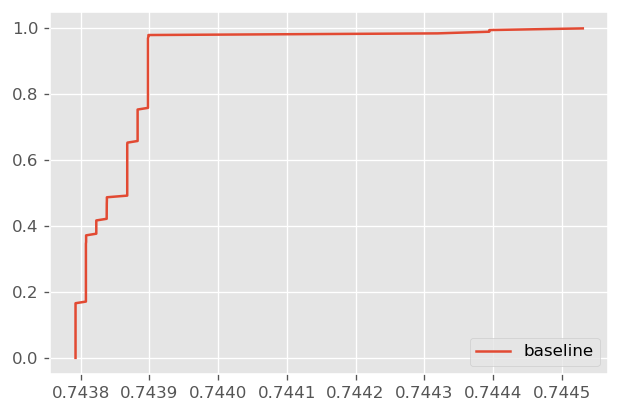

In [5]:
plt.figure(dpi=120)

auc_values_baseline = np.array([elem["value"] for elem in baseline_results])
t = np.linspace(0, 1, n_total)

plt.plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
plt.legend();

In [6]:
# models_baseline = get_top_k_models(baseline_results, top_k=top_k, stages_options=stages_options_baseline)
scores_baseline = get_top_test_scores(baseline_results, top_k=top_k, stages_options=stages_options_baseline, **sample_info)
print(scores_baseline)  # scores on test

  0%|          | 0/20 [00:00<?, ?it/s]

[0.76797721 0.76763533 0.76763533 0.76683761 0.76660969 0.76660969
 0.76592593 0.76592593 0.76592593 0.76592593 0.76592593 0.76592593
 0.76592593 0.76592593 0.76592593 0.76592593 0.76592593 0.76592593
 0.76592593 0.76592593]


# Categorical encoding

## Run models

In [20]:
from feature_engine.encoding import DecisionTreeEncoder, CountFrequencyEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

# -- additional categorical encoding options --
CF_encoder = CountFrequencyEncoder(variables=factors["cat_vals"], ignore_format=True)
setattr(CF_encoder, "pipeline_nm", "cat_feat_CF")

DT_encoder = DecisionTreeEncoder(variables=factors["cat_vals"], ignore_format=True, regression=False, random_state=seed)
setattr(DT_encoder, "pipeline_nm", "cat_feat_DT")
# -- --

stages_options_encoding = {
    "cat_feat" : [woe_encoder, CF_encoder, DT_encoder],  # changes only here
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip"],
    "classifier" : [logreg]
}

hparams_options_encoding = {
    "cat_feat_CF" : lambda trial: {
        "cat_feat_CF__encoding_method" : trial.suggest_categorical("cat_feat_CF__encoding_method", ["count", "frequency"])
    },
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [21]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_encoding.json", "r") as f:
        encoding_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_encoding = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_encoding.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_encoding, hparams_options=hparams_options_encoding, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )


    # -- save results to json --
    encoding_results = [
        {"value" : study_encoding.trials[i].value, "params" : study_encoding.trials[i].params} for i in range(len(study_encoding.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_encoding.json", "w") as f:
        json.dump(encoding_results, f)

[I 2022-04-28 11:51:23,290] A new study created in memory with name: no-name-1087990b-7c3a-4128-bfc5-385d4de34ff9
[I 2022-04-28 11:51:23,465] Trial 0 finished with value: 0.7438379484308553 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 10}. Best is trial 0 with value: 0.7438379484308553.
[I 2022-04-28 11:51:23,632] Trial 1 finished with value: 0.7438678503650361 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 49}. Best is trial 1 with value: 0.7438678503650361.
[I 2022-04-28 11:51:24,148] Trial 2 finished with value: 0.7317024940413139 and parameters: {'cat_feat': 2, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 36}. Best is trial 1 with value: 0.7438678503650361.
[I 2022-04-28 11:51:24,305] Trial 3 finished with value: 0.6635685953909765 and parameters: {'cat_feat': 1, 'scaling': 0, 'feat_sel': 0, 'imb_data':

## Results

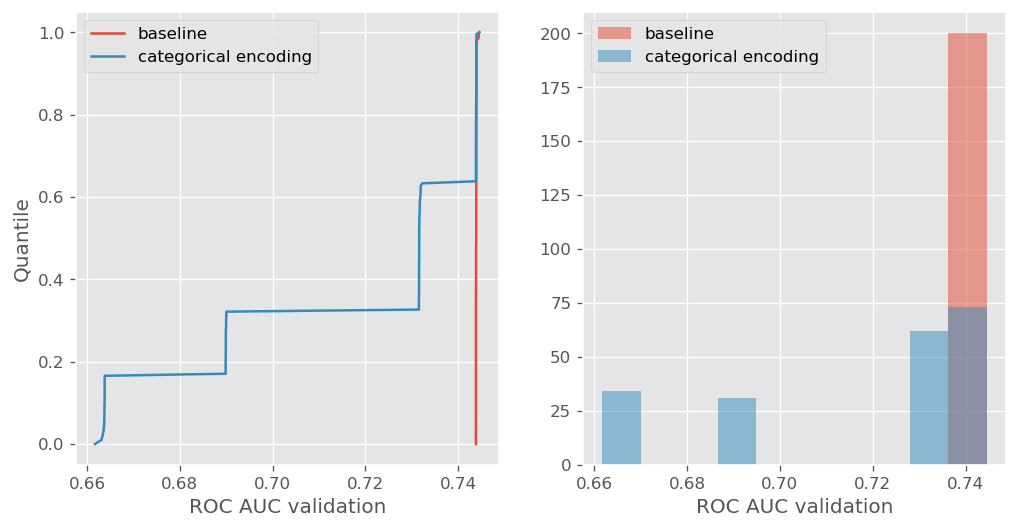

In [22]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_encoding = np.array([elem["value"] for elem in encoding_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_encoding])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_encoding), t, c="C1", label="categorical encoding")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_encoding, bins=bin_edges, alpha=0.5, label="categorical encoding")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [23]:
scores_encoding = get_top_test_scores(encoding_results, top_k=top_k, stages_options=stages_options_encoding, **sample_info)
print(np.mean(
    scores_encoding.reshape(-1, 1) > scores_baseline
))  # pairwise share of greater values

print(f"mean diff {np.mean(scores_encoding) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

0.0475
mean diff -0.000285


# Feature selection

## Run models

In [53]:
from modules.feature_selection import SafeSelectBySingleFeaturePerformance, SelectFromModel
from sklearn.svm import LinearSVC

# -- additional feature selection options --
SinglePerf_module = SafeSelectBySingleFeaturePerformance(  # rather slow
    estimator=LogisticRegression(max_iter=500),
    scoring="roc_auc",
    threshold=None,               # will be automatically set to the mean performance value of all features
)
setattr(SinglePerf_module, "pipeline_nm", "feat_sel_SinglePerf")

SM_selection = SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False), prefit=False, threshold="median")
setattr(SM_selection, "pipeline_nm", "feat_sel_SM")
# --- ---

stages_options_feat_sel = {
    "cat_feat" : [woe_encoder],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl, SinglePerf_module, SM_selection],  # changes only here
    "imb_data" : [],
    "classifier" : [logreg]
}

hparams_options_feat_sel = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    },
    "feat_sel_SinglePerf" : lambda trial: {
        "feat_sel_SinglePerf__threshold" : trial.suggest_float("feat_sel_SinglePerf__threshold", low=0.5, high=0.6)
    }
}

In [54]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_feat_sel.json", "r") as f:
        feat_sel_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_feat_sel = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_feat_sel.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_feat_sel, hparams_options=hparams_options_feat_sel, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )


    # -- save results to json --
    feat_sel_results = [
        {"value" : study_feat_sel.trials[i].value, "params" : study_feat_sel.trials[i].params} for i in range(len(study_feat_sel.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_feat_sel.json", "w") as f:
        json.dump(feat_sel_results, f)

[I 2022-04-28 13:03:15,937] A new study created in memory with name: no-name-22c53bd6-ad13-4280-9282-bf21964d6965
[I 2022-04-28 13:03:16,111] Trial 0 finished with value: 0.7437322433781537 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 10}. Best is trial 0 with value: 0.7437322433781537.
[I 2022-04-28 13:03:16,277] Trial 1 finished with value: 0.7438678503650362 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 49}. Best is trial 1 with value: 0.7438678503650362.
[I 2022-04-28 13:03:16,331] Trial 2 finished with value: 0.7644618940282641 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 2, 'classifier': 0, 'classifier_LogReg__C': 36}. Best is trial 2 with value: 0.7644618940282641.
[I 2022-04-28 13:03:16,597] Trial 3 finished with value: 0.7702348624031268 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 1, 'classifier': 0, 'feat_sel_SinglePerf__threshold': 0.540

## Results

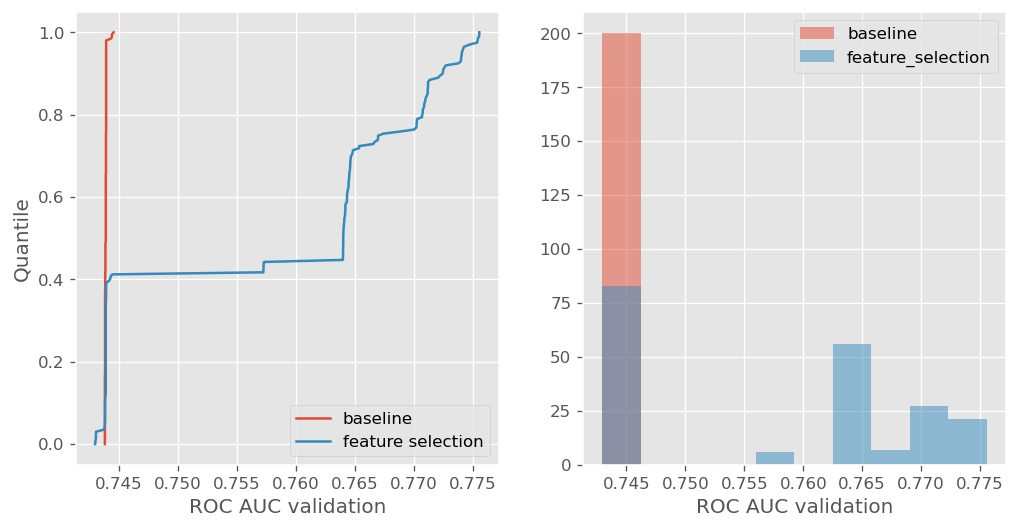

In [55]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_feat_sel = np.array([elem["value"] for elem in feat_sel_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_feat_sel])


ax[0].plot(np.sort(auc_values_baseline), np.linspace(0, 1, len(auc_values_baseline)), c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_feat_sel), np.linspace(0, 1, len(auc_values_feat_sel)), c="C1", label="feature selection")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_feat_sel, bins=bin_edges, alpha=0.5, label="feature_selection")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [56]:
scores_feat_sel = get_top_test_scores(feat_sel_results, top_k=top_k, stages_options=stages_options_feat_sel, **sample_info)
print(scores_feat_sel)
print(np.mean(
    scores_feat_sel.reshape(-1, 1) > scores_baseline
))

print(f"mean diff {np.mean(scores_feat_sel) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

[0.76877493 0.76877493 0.76740741 0.76877493 0.76843305 0.76717949
 0.77025641 0.76877493 0.76877493 0.77025641 0.76547009 0.77014245
 0.77037037 0.77037037 0.77025641 0.77025641 0.77698006 0.77481481
 0.77663818 0.77470085]
0.935
mean diff 0.004057


# Imbalanced data

## Run models

In [33]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# -- additional oversampling options --
ROS_module    = RandomOverSampler(random_state=seed)   # for all algorithms
setattr(ROS_module, "pipeline_nm", "imb_data_ROS")

SMOTE_module  = SMOTE(random_state=seed, n_jobs=-1)    # is to equalize
setattr(SMOTE_module, "pipeline_nm", "imb_data_SMOTE")

ADASYN_module = ADASYN(random_state=seed)              # the two classes
setattr(ADASYN_module, "pipeline_nm", "imb_data_ADASYN")

stages_options_imbalanced = {
    "cat_feat" : [woe_encoder],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip", ROS_module, SMOTE_module, ADASYN_module],  # changes only here
    "classifier" : [logreg]
}

hparams_options_imbalanced = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [34]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_imbalanced.json", "r") as f:
        imbalanced_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_imbalanced = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_imbalanced.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_imbalanced, hparams_options=hparams_options_imbalanced, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    imbalanced_results = [
        {"value" : study_imbalanced.trials[i].value, "params" : study_imbalanced.trials[i].params} for i in range(len(study_imbalanced.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_imbalanced.json", "w") as f:
        json.dump(imbalanced_results, f)

[I 2022-04-28 12:01:15,629] A new study created in memory with name: no-name-91ac4ebe-05a5-4f88-9de9-2d3358d10a1a
[I 2022-04-28 12:01:15,800] Trial 0 finished with value: 0.7438678503650361 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 57}. Best is trial 0 with value: 0.7438678503650361.
[I 2022-04-28 12:01:15,976] Trial 1 finished with value: 0.743014896467262 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 2, 'classifier': 0, 'classifier_LogReg__C': 42}. Best is trial 0 with value: 0.7438678503650361.
[I 2022-04-28 12:01:16,150] Trial 2 finished with value: 0.7438379484308553 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 11}. Best is trial 0 with value: 0.7438678503650361.
[I 2022-04-28 12:01:16,338] Trial 3 finished with value: 0.7442365328816775 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 

## Results

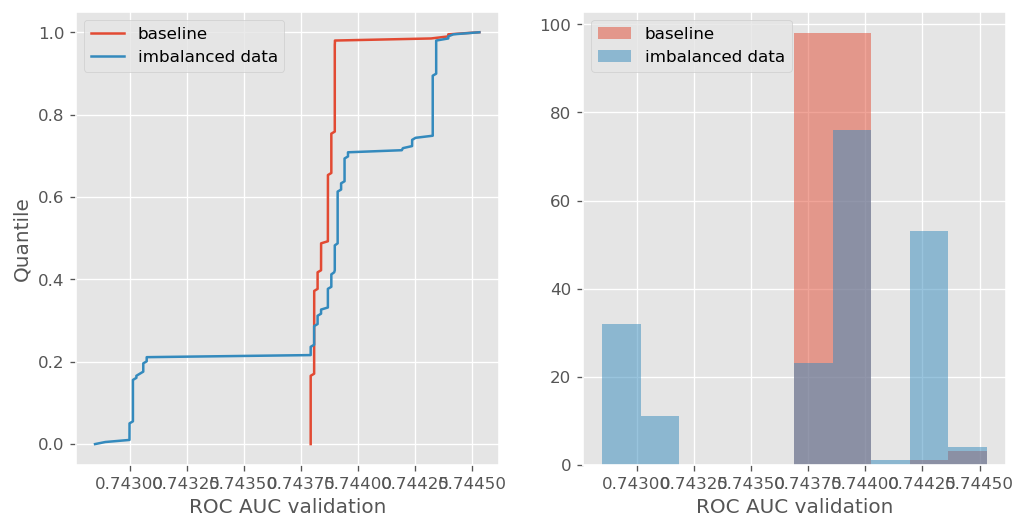

In [35]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_imbalanced = np.array([elem["value"] for elem in imbalanced_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_imbalanced])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_imbalanced), t, c="C1", label="imbalanced data")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_imbalanced, bins=bin_edges, alpha=0.5, label="imbalanced data")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [36]:
scores_imbalanced = get_top_test_scores(imbalanced_results, top_k=top_k, stages_options=stages_options_imbalanced, **sample_info)
print(np.mean(
    scores_imbalanced.reshape(-1, 1) > scores_baseline
))

print(f"mean diff {np.mean(scores_imbalanced) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

0.1325
mean diff -0.004165


# Classifier choice

## Run models

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# change solver to allow for l1 penalty
setattr(logreg, "solver", "liblinear")

GP_model = GaussianProcessClassifier()
setattr(GP_model, "pipeline_nm", "classifier_GP")

lda = LinearDiscriminantAnalysis()
setattr(lda, "pipeline_nm", "classifier_LDA")

stages_options_classifier = {
    "cat_feat" : [woe_encoder],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip"],
    "classifier" : [logreg, GP_model]  # changes only here
}

hparams_options_classifier = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__penalty" : trial.suggest_categorical("classifier_LogReg__penalty", ["l1", "l2"]),
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    },
    "classifier_Tree" : lambda trial: {
        "classifier_Tree__max_depth" : trial.suggest_int("classifier_Tree__max_depth", low=1, high=3, step=1),
        "classifier_Tree__min_samples_split" : trial.suggest_int("classifier_Tree__min_samples_split", 5, 10, step=1)
    },
}

In [47]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_classifier.json", "r") as f:
        classifier_results = json.load(f)
else:
    # -- run grid search --
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
    study_classifier = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_classifier.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_classifier, hparams_options=hparams_options_classifier, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    classifier_results = [
        {"value" : study_classifier.trials[i].value, "params" : study_classifier.trials[i].params} for i in range(len(study_classifier.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_classifier.json", "w") as f:
        json.dump(classifier_results, f)

[I 2022-04-28 12:18:58,787] A new study created in memory with name: no-name-a866c81f-d2b9-43f7-b26c-f4e0ddde90e3
[I 2022-04-28 12:18:58,958] Trial 0 finished with value: 0.7438678503650362 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__penalty': 'l1', 'classifier_LogReg__C': 57}. Best is trial 0 with value: 0.7438678503650362.
[I 2022-04-28 12:18:59,329] Trial 1 finished with value: 0.7392941532172493 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 1}. Best is trial 0 with value: 0.7438678503650362.
[I 2022-04-28 12:18:59,507] Trial 2 finished with value: 0.7437926462654117 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__penalty': 'l2', 'classifier_LogReg__C': 36}. Best is trial 0 with value: 0.7438678503650362.
[I 2022-04-28 12:18:59,833] Trial 3 finished with value: 0.7392941532172493 and parameters: {'cat_feat':

## Results

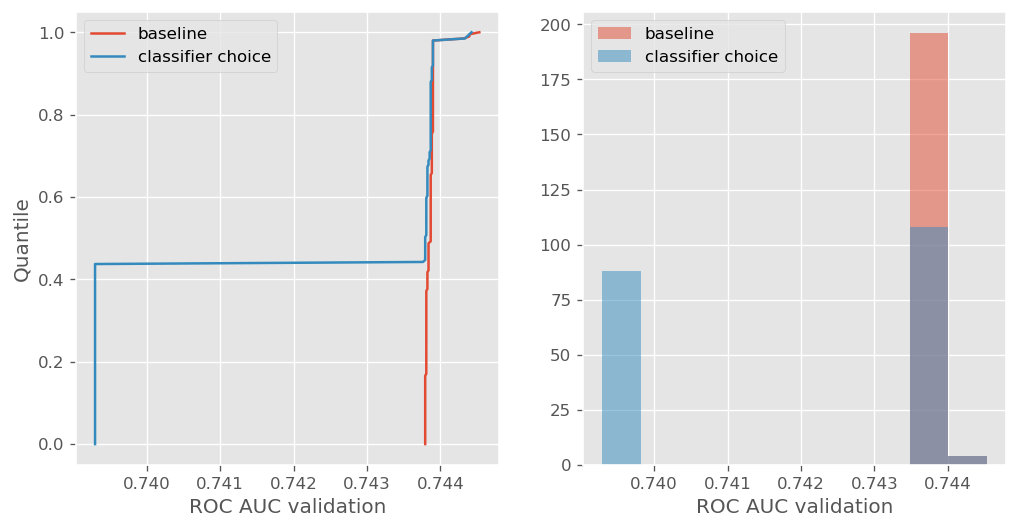

In [48]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_classifier = np.array([elem["value"] for elem in classifier_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_classifier])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_classifier), t, c="C1", label="classifier choice")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_classifier, bins=bin_edges, alpha=0.5, label="classifier choice")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [49]:
# models_baseline = get_top_k_models(baseline_results, top_k=top_k, stages_options=stages_options_baseline)
scores_classifier = get_top_test_scores(classifier_results, top_k=top_k, stages_options=stages_options_classifier, **sample_info)
print(scores_classifier)
print(np.mean(
    scores_classifier.reshape(-1, 1) > scores_baseline
))
print(f"mean diff {np.mean(scores_classifier) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

[0.76649573 0.76752137 0.76809117 0.76683761 0.76592593 0.76581197
 0.76592593 0.76592593 0.76592593 0.76592593 0.76592593 0.76581197
 0.76592593 0.76592593 0.76592593 0.76592593 0.76592593 0.76581197
 0.76592593 0.76581197]
0.1675
mean diff -0.000148
